## Imports

In [148]:
import os
import numpy as np
import torch
import torch.nn as nn
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset
import cv2 as cv
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torchsummary import summary
import nibabel as nib
from tqdm import tqdm
import torch.nn.functional as F

print('imported')

imported


### Preparing data

In [150]:
# constants
base_directory = './Brats_only_lesion_max_ROI/'
train_patient_list = os.listdir(base_directory + 'train/')
test_patient_list = os.listdir(base_directory + 'test/')

train_patient_list = train_patient_list[: len(train_patient_list)]
test_patient_list = test_patient_list[: len(test_patient_list)]

slices_per_patient = 96
num_slices_selected = 3

In [151]:
class BratsDataset(Dataset):
    def __init__(self, mode, transform=None):
        super(BratsDataset, self).__init__()
        self.mode = mode
        self.transform = transform
        self.patient_list = train_patient_list if mode == 'train' else test_patient_list
        self.directory = base_directory + mode + '/'

        self.x = []
        for patient in tqdm(self.patient_list):
            self.x.append(
                np.stack([
                    nib.load(self.directory + patient + '/' + patient + '_best_slices/' + patient + mri_type + '.nii.gz').get_fdata()
                    for mri_type in ['_flair', '_seg', '_t1', '_t1ce', '_t2']
                ], axis=-1)
            )
        self.x = np.stack(self.x, axis=0)

    def __len__(self):
        return len(self.patient_list)

    def get_data(self):
        return self.x

    def __getitem__(self, idx):
        # pour avori l'idx d'un patient
        sequence = self.x[idx]

        # standardize the sequence
        sequence = torch.Tensor(cv.normalize(sequence.transpose(2, 0, 1), None, 0, 1, cv.NORM_MINMAX))

        # on normalise les images
        if self.transform:
            sequence = self.transform(sequence)
            sequence_other = self.transform(sequence_other)

        return sequence

In [152]:
train_dataset = BratsDataset('train', transform=None)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 1051/1051 [00:39<00:00, 26.36it/s]


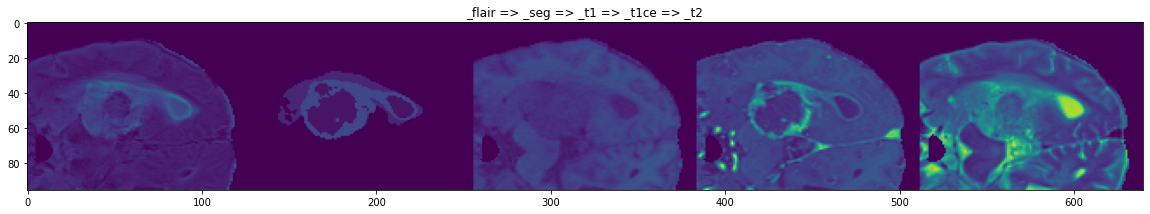

In [209]:
def show_irm(irm):
    irm[:, :, 1] *= 90  # random constant just to make the plot more visible
    irm = irm.transpose(2, 0, 1)
    irm = np.hstack([s for s in irm])
    plt.figure(figsize=(20, 20))
    plt.title(' => '.join(['_flair', '_seg', '_t1', '_t1ce', '_t2']))
    plt.imshow(irm)

show_irm(train_dataset.x[np.random.randint(0, len(train_dataset))])

### Defining model

In [187]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [190]:
# Define the Contrastive Loss Function
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
      loss_contrastive = torch.mean((1 - label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

      return loss_contrastive

class Autoencoder(nn.Module):
    def __init__(self, latent_dim=256):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=5, out_channels=32, kernel_size=3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.Conv2d(256, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.Flatten(),
            nn.Linear(256 * 3 * 4, self.latent_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.latent_dim, 256 * 3 * 4),
            nn.Unflatten(1, (256, 3, 4)),
            nn.ConvTranspose2d(self.latent_dim, 256, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(256, momentum=0.9),
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(128, momentum=0.9),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(64, momentum=0.9),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.LeakyReLU(0.1, inplace=True),
            nn.BatchNorm2d(32, momentum=0.9),
            nn.ConvTranspose2d(32, 5, 3, stride=2, padding=1, output_padding=1),
            nn.Tanh()
        )

    def encode(self, x):
        return self.encoder(x)

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def train_reconstruction(self, loader, epochs=10, lr=0.001):
        self.to(device)
        self.train()
        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = nn.MSELoss()
        for epoch in range(epochs):
            for i, x in enumerate(loader):
                x = x.to(device)
                optimizer.zero_grad()
                x_reconstructed = self.forward(x)
                loss = criterion(x_reconstructed, x)
                loss.backward()
                optimizer.step()
                if i % 100 == 0:
                    print(f"Epoch {epoch}, batch {i}/{len(loader)}, loss {loss.item()}")

summary(Autoencoder().to(device), (5, 96, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 48, 64]           1,472
         LeakyReLU-2           [-1, 32, 48, 64]               0
       BatchNorm2d-3           [-1, 32, 48, 64]              64
            Conv2d-4           [-1, 64, 24, 32]          18,496
         LeakyReLU-5           [-1, 64, 24, 32]               0
       BatchNorm2d-6           [-1, 64, 24, 32]             128
            Conv2d-7          [-1, 128, 12, 16]          73,856
         LeakyReLU-8          [-1, 128, 12, 16]               0
       BatchNorm2d-9          [-1, 128, 12, 16]             256
           Conv2d-10            [-1, 256, 6, 8]         295,168
        LeakyReLU-11            [-1, 256, 6, 8]               0
      BatchNorm2d-12            [-1, 256, 6, 8]             512
           Conv2d-13            [-1, 256, 3, 4]         590,080
        LeakyReLU-14            [-1, 25

In [191]:
ae = Autoencoder().to(device)
ae.train_reconstruction(train_loader, epochs=300, lr=0.001)

Epoch 0, batch 0/17, loss 0.2964544892311096
Epoch 1, batch 0/17, loss 0.07200141996145248
Epoch 2, batch 0/17, loss 0.04902549088001251
Epoch 3, batch 0/17, loss 0.03608373925089836
Epoch 4, batch 0/17, loss 0.026076750829815865
Epoch 5, batch 0/17, loss 0.026903817430138588
Epoch 6, batch 0/17, loss 0.02341635525226593
Epoch 7, batch 0/17, loss 0.021090183407068253
Epoch 8, batch 0/17, loss 0.020217183977365494
Epoch 9, batch 0/17, loss 0.018041932955384254
Epoch 10, batch 0/17, loss 0.014342446811497211
Epoch 11, batch 0/17, loss 0.011765996925532818
Epoch 12, batch 0/17, loss 0.010169172659516335
Epoch 13, batch 0/17, loss 0.009895075112581253
Epoch 14, batch 0/17, loss 0.009968813508749008
Epoch 15, batch 0/17, loss 0.009724569506943226
Epoch 16, batch 0/17, loss 0.009715965948998928
Epoch 17, batch 0/17, loss 0.01097703818231821
Epoch 18, batch 0/17, loss 0.010061418637633324
Epoch 19, batch 0/17, loss 0.009075788781046867
Epoch 20, batch 0/17, loss 0.00899934396147728
Epoch 21, 

## Visual comparison of the results 

In [277]:
# we keep sample indexes to plot the results, for visual comparison
signatures = []
indexes = np.random.randint(0, len(train_dataset), size=100)
for i in indexes:
    x = train_dataset[i].to(device)
    x_latent = ae.encode(x.expand(1, 5, 96, 128))
    x_latent = x_latent.detach().cpu().numpy()
    signatures.append(x_latent)

distance_matrix = np.zeros((100, 100))
for i in range(10):
    for j in range(10):
        distance_matrix[i, j] = np.linalg.norm(signatures[i] - signatures[j])

query_idx = np.random.randint(0, 10)
query_original_idx = indexes[query_idx]

most_similar_idx = np.argsort(distance_matrix[query_idx])[:3] # les 3 premiers
most_similar_original_idx = indexes[most_similar_idx]

most_dissimilar_idx = np.argsort(distance_matrix[query_idx])[-3:] # les 3 derniers
most_dissimilar_original_idx = indexes[most_dissimilar_idx]

In [278]:
# distances
distance_matrix[query_idx, most_similar_idx], distance_matrix[query_idx, most_dissimilar_idx]

(array([0., 0., 0.]), array([156.2686615 , 168.25378418, 219.82315063]))

#### Query IRM

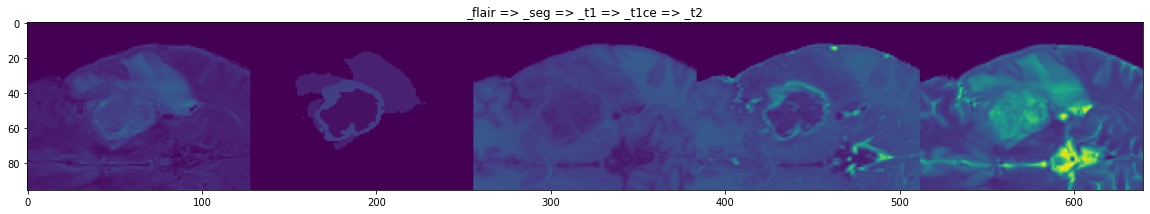

In [279]:
show_irm(train_dataset.x[query_original_idx])

#### 3 Most similar IRMs

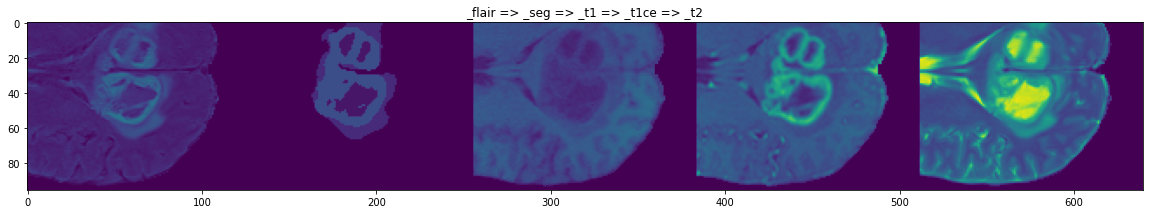

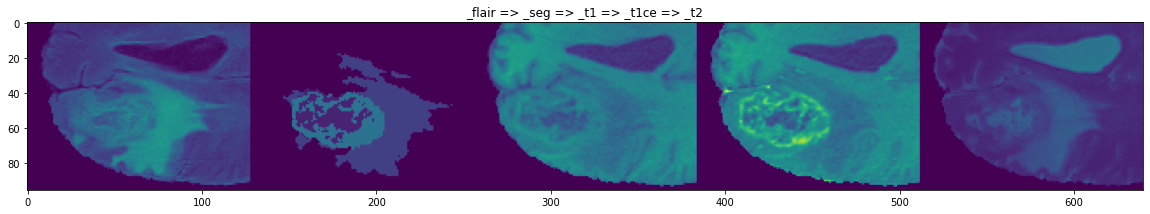

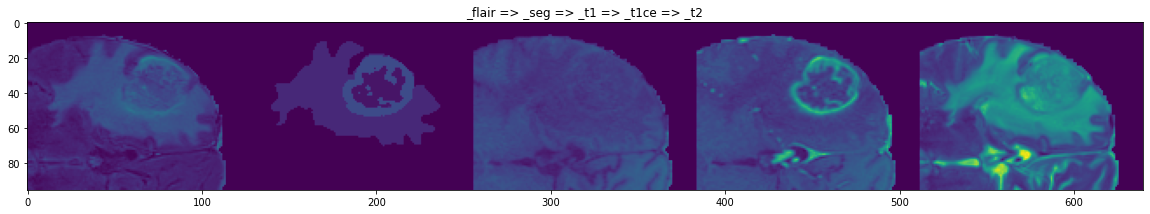

In [280]:
for i in most_similar_original_idx:
    show_irm(train_dataset.x[i])

### 3 Most dissimilar IRMs

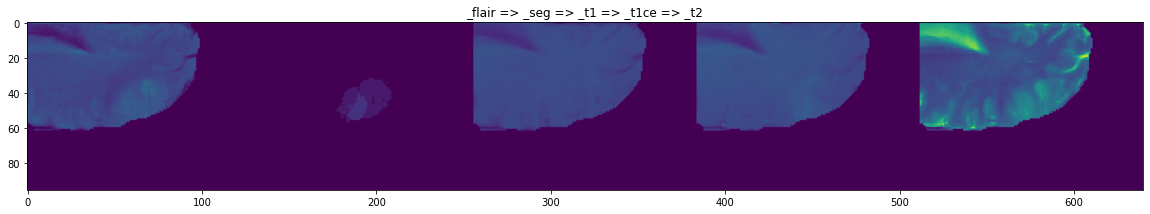

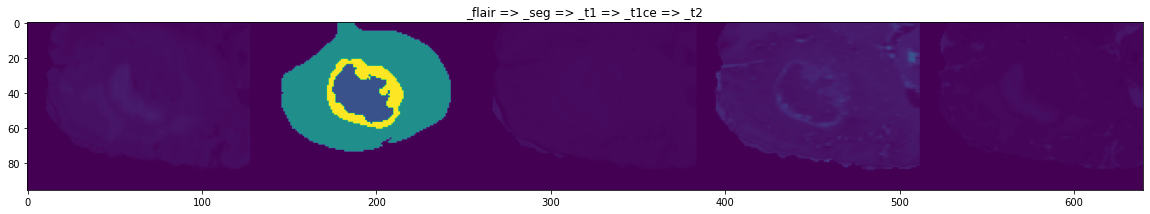

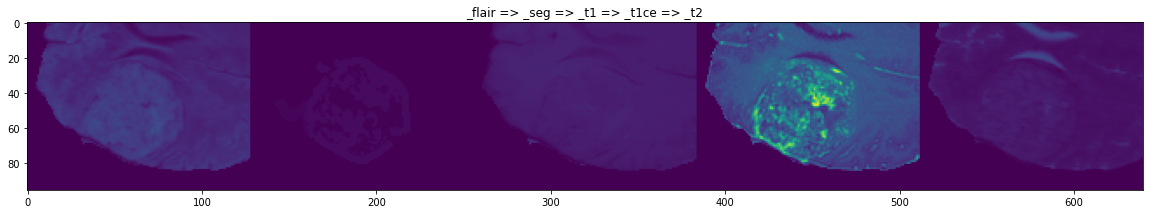

In [281]:
for i in most_dissimilar_original_idx:
    show_irm(train_dataset.x[i])

# Saving and loading model

##### 1. Save

In [260]:
torch.save(ae, 'model.pth')
print('model saved')

model saved


##### 2. Load

In [261]:
ae = torch.load('model.pth')
# ne pas oublier car j'utilise un batchNorm
ae.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(5, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1, inplace=True)
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.1, inplace=True)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): LeakyReLU(negative_slope=0.1, inplace=True)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (9): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): LeakyReLU(negative_slope=0.1, inplace=True)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): 